# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [18]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [19]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

In [ ]:
# image size
trainloader.dataset[0][0].size()

torch.Size([3, 32, 32])

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs. 
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [24]:
class Net(nn.Module):
    def __init__(self, channels:list[int]=[32,64,128,256], kernel_size=3, padding=1, pool_size=tuple([2,2]), pool_stride=2,
                dropout=0.2, num_of_classes=10):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
        layers = []
        
        channels.insert(0, 3)
        
        for i, channel in enumerate(channels[1:], start=1):
            layers.extend([nn.Conv2d(in_channels=channels[i-1], out_channels=channel,
                                     kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(num_features=channel),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_size, stride=pool_stride)])

        self.conv = nn.Sequential(*layers)

        # after 4 layers -> picture dimention is 256 * 2 * 2 (channels x H x W) = 1024
        # 2 x 2 = 32 / (2*4)
        self.fc_layers = nn.Sequential(
            nn.Linear(channels[-1] * 2 * 2, 1024),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(1024, 200),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(200, num_of_classes)
        )

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################
        x = self.conv(x)
        flatten = nn.Flatten(start_dim=1, end_dim=-1)
        x = flatten(x) # n x (256 x 2 x 2)
        x = self.fc_layers(x)
        soft_max = nn.Softmax(dim=1)
        return soft_max(x)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

# net = Net().to(device)
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   # 
#############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [25]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        # 
#############################################################################
def train_step(dataloader, net, criterion, optimizer):
    loss_hist = []

    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # forward + backward + optimize
        pred = net(x_batch)
        loss = criterion(pred, y_batch)
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss.item())

    return np.mean(loss_hist)

def train_accuracy(dataloader, net):
    total = len(dataloader.dataset)
    correct = 0

    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        pred = net(x_batch)
        _, predicted = torch.max(pred.data, 1)
        correct += (predicted == y_batch).sum().item()

    return correct / total
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [26]:
# Training the model
num_of_epochs = 7
train_loss = []
accuracy = []

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.8)

for epoch in range(num_of_epochs):
    net.train()
    print(f'Epoch: {epoch+1}/{num_of_epochs}')
    print('-' * 10)
    train_loss.append(train_step(trainloader, net, criterion, optimizer))
    accuracy.append(train_accuracy(trainloader, net))
    print(f'Train loss: {train_loss[-1]}, Accuracy: {accuracy[-1]}')
    

Epoch: 1/7
----------
Train loss: 2.1284339510266435, Accuracy: 0.47678
Epoch: 2/7
----------
Train loss: 1.9167421199476626, Accuracy: 0.60316
Epoch: 3/7
----------
Train loss: 1.8414847803542682, Accuracy: 0.6559
Epoch: 4/7
----------
Train loss: 1.7964842113692436, Accuracy: 0.69602
Epoch: 5/7
----------
Train loss: 1.7664087686087468, Accuracy: 0.7257
Epoch: 6/7
----------
Train loss: 1.7391921077542902, Accuracy: 0.74272
Epoch: 7/7
----------
Train loss: 1.716900015121226, Accuracy: 0.76152


In [30]:
import seaborn as sns
sns.set()

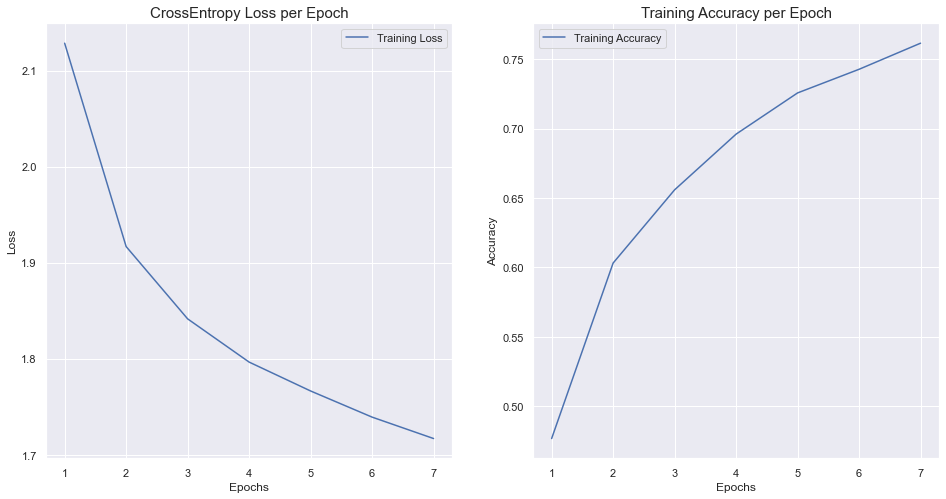

In [28]:
x = np.arange(1,num_of_epochs + 1)
fig, ax = plt.subplots(1, 2, figsize=(16,8))
sns.lineplot(y=train_loss, x=x, ax=ax[0], label='Training Loss')
sns.lineplot(y=accuracy, x=x, ax=ax[1], label='Training Accuracy')
ax[0].set_title("CrossEntropy Loss per Epoch", fontsize=15)
ax[1].set_title("Training Accuracy per Epoch", fontsize=15)
ax[0].set(xlabel="Epochs", ylabel='Loss')
ax[1].set(xlabel="Epochs", ylabel='Accuracy');


## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)** 

In [29]:
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################
def test_step(dataloader, net):
     net.eval()
     total = len(dataloader.dataset)
     model_accuracy = 0
     correct = 0
     confusion_matrix = np.zeros([10,10], int)

     with torch.no_grad():
          for x_batch, y_batch in dataloader:
               x_batch, y_batch = x_batch.to(device), y_batch.to(device)

               pred = net(x_batch)
               _, predicted = torch.max(pred.data, 1)
               correct += (predicted == y_batch).sum().item()

               for i in range(len(y_batch)):
                    confusion_matrix[y_batch[i],predicted[i]] += 1

          model_accuracy = correct / total

     return confusion_matrix, model_accuracy


confusion_matrix, model_accuracy = test_step(testloader, net)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy*100))

Model accuracy on 10000 test images: 72.20%


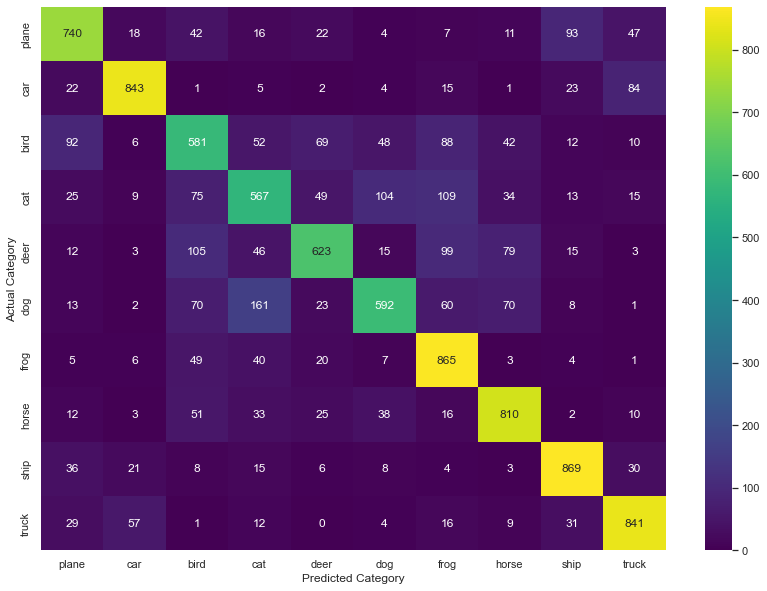

In [ ]:

fig, ax = plt.subplots(1,1,figsize=(14,10))
sns.heatmap(confusion_matrix,cmap='viridis' ,ax=ax, annot=True, vmin=0, fmt=".0f")
ax.set(ylabel='Actual Category', xlabel='Predicted Category')
ax.set_yticklabels(classes)
ax.set_xticklabels(classes);

In [ ]:
print ("Accuracy per class")
class_appearances = np.sum(confusion_matrix, axis=1)
for i, cl in enumerate(classes):
    print(f"Class: {cl}\t Accuracy: {confusion_matrix[i,i] / class_appearances[i]}")

Accuracy per class
Class: plane	 Accuracy: 0.74
Class: car	 Accuracy: 0.843
Class: bird	 Accuracy: 0.581
Class: cat	 Accuracy: 0.567
Class: deer	 Accuracy: 0.623
Class: dog	 Accuracy: 0.592
Class: frog	 Accuracy: 0.865
Class: horse	 Accuracy: 0.81
Class: ship	 Accuracy: 0.869
Class: truck	 Accuracy: 0.841


##**Question:** 
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:** Initially, I tried to train a simpler model with only two Conv layers (32 and 64 channels) and one FC layer. In addition, I used a learning rate of 0.001 and a momentum of 0.9, which made the model converge slowly and get insufficient accuracy due to the effect of the previous gradients. 
Trying to improve accuracy and the convergence rate, I added two more Conv layers (128 and 256 channels), a FC layer, and a dropout layer to avoid overfitting.
Furthermore, to speed up the training, I added batch normalization to the layers, used a higher learning rate of 0.01, and decreased the momentum to 0.8. 
As a result, the model converged faster than before, and the model's accuracy increased.

##**Question:** 
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:** 
By looking at the confusion matrix, we can learn which classes the model could predict more effectively and which were challenging.

Observing the accuracy results, the model can distinguish between animals and vehicles well, and the model tends to classify vehicle classes better than animals.
Nevertheless, it is more challenging to identify the classes among their types. The model tends to classify animals with other types of animals and vehicles with different types of vehicles.

# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [ ]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [ ]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/giladkatz/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 10.8MB/s]


ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [ ]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

In [ ]:
sample["image"].shape # 32 photos(batch size), 3 channels of 224 x 224

torch.Size([32, 3, 224, 224])

<Figure size 864x576 with 0 Axes>

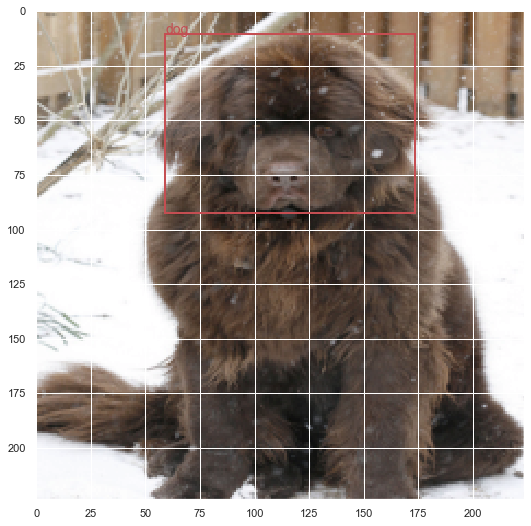

In [ ]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only      #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # This function has no return value.                                        #
        #############################################################################
        in_features = resnet18.fc.in_features
        # Using pre-trained resnet18 layers, except the last FC layer.
        self.model_layers = nn.Sequential(*list(resnet18.children())[:-1])
        # My FC layer
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(256, num_classes)
        )

        self.bbox_model = nn.Sequential(
            nn.Linear(in_features, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 4)
        )

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        with torch.no_grad():
            features = self.model_layers(images)
            flatten = nn.Flatten(start_dim=1, end_dim=-1)
            features = flatten(features)

        # predict class_score
        class_scores = self.fc_layer(features)
        soft_max = nn.Softmax(dim=1)
        class_scores = soft_max(class_scores)

        # bbox prediction
        bbox_prediction = self.bbox_model(features)
        
        return class_scores, bbox_prediction
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [ ]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    train_val_dict = {"train_loss_hist": [], "val_loss_hist": [],
                        "train_acc_hist": [], "val_acc_hist": [],
                        "train_iou": [], "val_iou": []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score
            
            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                images = sample["image"].to(device)
                labels = sample["label"].to(device)
                bbox = sample["bbox"].to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                is_train = phase == "train"
                with torch.set_grad_enabled(is_train):
                    # forward
                    class_scores, bbox_prediction = model(images)
                    cls_loss = criterion_cls(class_scores, labels)
                    bbox_loss = criterion_bbox(bbox_prediction, bbox)
                    loss = cls_loss + bbox_loss

                    # Calculate accuracy
                    _, cls_preds = torch.max(class_scores, 1)
                    running_corrects += (cls_preds == labels).sum().item()

                    # IoU score
                    for box in range(len(bbox)):
                        iou += bb_intersection_over_union(bbox[box], bbox_prediction[box]) 
                    
                    # backward + optimize
                    if is_train:
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * images.size(0) 
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = float(running_corrects) / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]
            
            if is_train:
                train_val_dict["train_loss_hist"].append(epoch_loss)
                train_val_dict["train_acc_hist"].append(epoch_acc)
                train_val_dict["train_iou"].append(iou)
            else:
                train_val_dict["val_loss_hist"].append(epoch_loss)
                train_val_dict["val_acc_hist"].append(epoch_acc)
                train_val_dict["val_iou"].append(iou)
            
            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_val_dict

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [ ]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [ ]:
best_model, train_val_dict = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.4558  |  Acc: 0.9371  |  IOU: 0.6620
val Loss: 0.3691  |  Acc: 0.9810  |  IOU: 0.7168
Epoch 2/10
----------
train Loss: 0.3573  |  Acc: 0.9811  |  IOU: 0.7298
val Loss: 0.3513  |  Acc: 0.9873  |  IOU: 0.7295
Epoch 3/10
----------
train Loss: 0.3507  |  Acc: 0.9827  |  IOU: 0.7469
val Loss: 0.3498  |  Acc: 0.9810  |  IOU: 0.7415
Epoch 4/10
----------
train Loss: 0.3400  |  Acc: 0.9937  |  IOU: 0.7608
val Loss: 0.3488  |  Acc: 0.9810  |  IOU: 0.7539
Epoch 5/10
----------
train Loss: 0.3397  |  Acc: 0.9890  |  IOU: 0.7684
val Loss: 0.3416  |  Acc: 0.9873  |  IOU: 0.7570
Epoch 6/10
----------
train Loss: 0.3529  |  Acc: 0.9733  |  IOU: 0.7703
val Loss: 0.3696  |  Acc: 0.9684  |  IOU: 0.7472
Epoch 7/10
----------
train Loss: 0.3502  |  Acc: 0.9780  |  IOU: 0.7707
val Loss: 0.3403  |  Acc: 0.9873  |  IOU: 0.7627
Epoch 8/10
----------
train Loss: 0.3338  |  Acc: 0.9937  |  IOU: 0.7790
val Loss: 0.3472  |  Acc: 0.9810  |  IOU: 0.7685
Epoch 9/10
----------
tr

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

<Figure size 864x576 with 0 Axes>

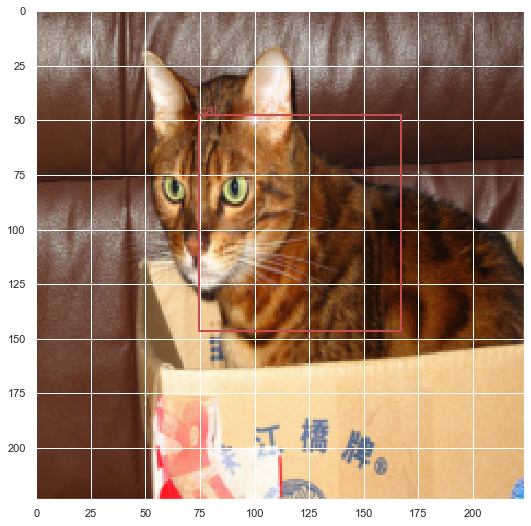

In [ ]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

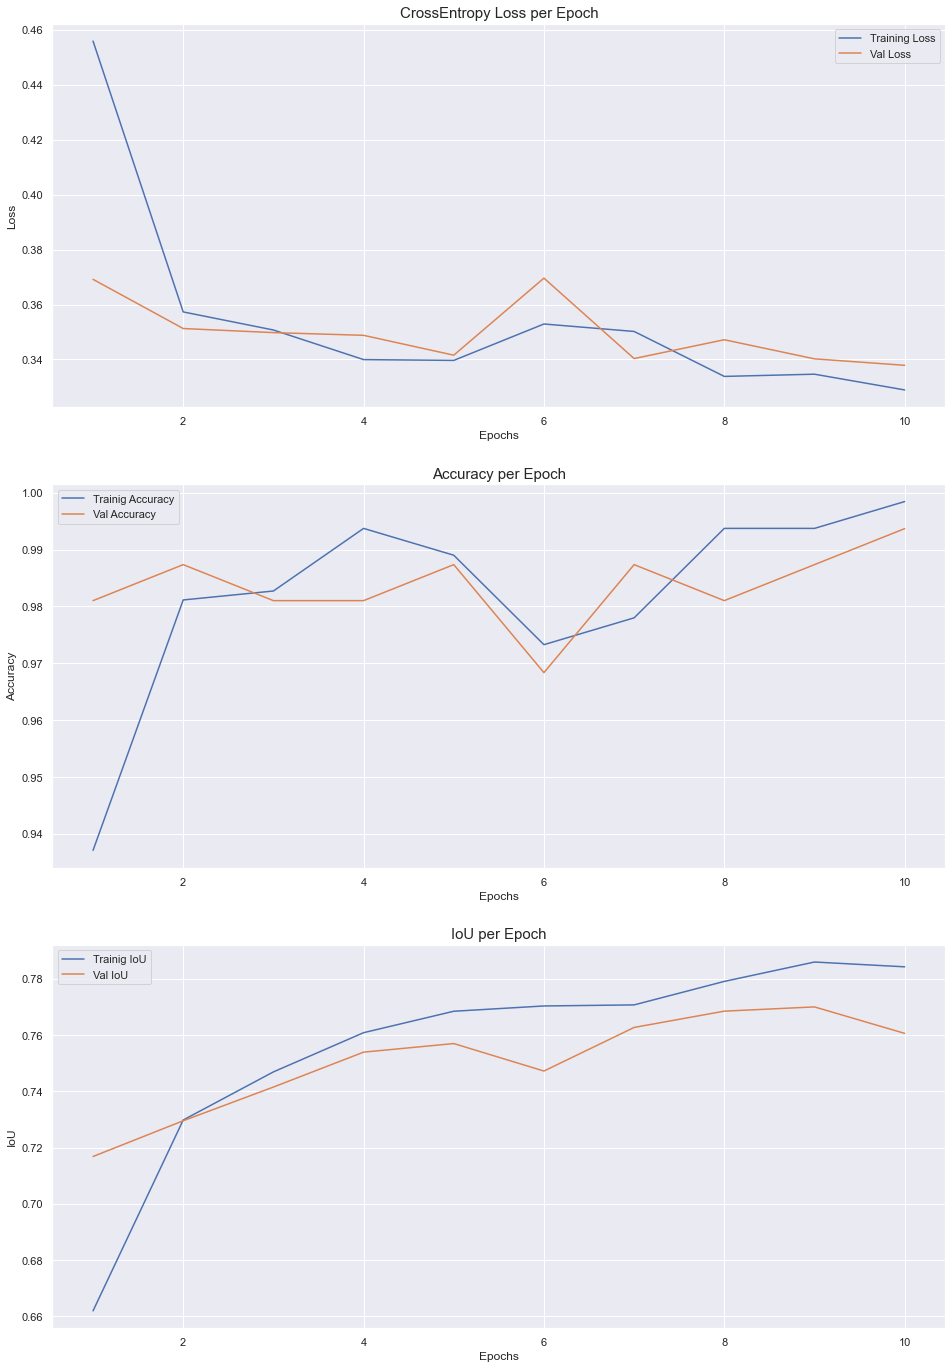

In [ ]:
num_of_epochs = 10
x = np.arange(1,num_of_epochs + 1)
fig, ax = plt.subplots(3, 1, figsize=(16,24))
sns.lineplot(y=train_val_dict["train_loss_hist"], x=x, ax=ax[0], label='Training Loss')
sns.lineplot(y=train_val_dict["val_loss_hist"], x=x, ax=ax[0], label='Val Loss')
sns.lineplot(y=train_val_dict["train_acc_hist"], x=x, ax=ax[1], label='Trainig Accuracy')
sns.lineplot(y=train_val_dict["val_acc_hist"], x=x, ax=ax[1], label='Val Accuracy')
sns.lineplot(y=train_val_dict["train_iou"], x=x, ax=ax[2], label='Trainig IoU')
sns.lineplot(y=train_val_dict["val_iou"], x=x, ax=ax[2], label='Val IoU')

ax[0].set_title("CrossEntropy Loss per Epoch", fontsize=15)
ax[1].set_title("Accuracy per Epoch", fontsize=15)
ax[2].set_title("IoU per Epoch", fontsize=15)
ax[0].set(xlabel="Epochs", ylabel='Loss')
ax[1].set(xlabel="Epochs", ylabel='Accuracy')
ax[2].set(xlabel="Epochs", ylabel='IoU');


# Results:
#### Loss:
I defined the loss function as CrossEntropy for the labels, as in the first part of the assignment, and MSELoss for the bounding box. <br>
We can notice by looking at the graph a significant decrease in the training loss after the first epoch, and an excellent overall decline in both training and Val losses. 

#### Accuracy:
We can see a big jump in the Training accuracy from the first epoch to the second. Similar to what we saw in the training loss. 
Nevertheless, from the second to the eighth epoch, there is no clear trend in the graph. However, from the eighth epoch, we can see a nice increase in accuracy. <br>
The accuracy of the Val is high, to begin with, and there is no significant improvement change over time but the last two epochos.
This scenario can exist due to the reason that we are using a pre-trained model.

#### IoU:
Similar to the Training loss and Training accuracy, we can notice a significant movement in the score from the first to the second epoch.<br>
In both Training and Val UoI, we can see an upward trend, as we expected to see.
